In [1]:
%pylab inline

import jax
import jax.numpy as jnp
import jax_cosmo as jc

from jax.experimental.ode import odeint

from jaxpm.painting import cic_paint
from jaxpm.pm import linear_field, lpt, make_ode_fn

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
mesh_shape= [128, 128, 128]
box_size  = [128.,128.,128.]
snapshots = jnp.linspace(0.1,1.,2)

@jax.jit
def run_simulation(omega_c, sigma8):
    # Create a small function to generate the matter power spectrum
    k = jnp.logspace(-4, 1, 128)
    pk = jc.power.linear_matter_power(jc.Planck15(Omega_c=omega_c, sigma8=sigma8), k)
    pk_fn = lambda x: jc.scipy.interpolate.interp(x.reshape([-1]), k, pk).reshape(x.shape)

    # Create initial conditions
    initial_conditions = linear_field(mesh_shape, box_size, pk_fn, seed=jax.random.PRNGKey(0))

    # Create particles
    particles = jnp.stack(jnp.meshgrid(*[jnp.arange(s) for s in mesh_shape]),axis=-1).reshape([-1,3])

    cosmo = jc.Planck15(Omega_c=omega_c, sigma8=sigma8)
    
    # Initial displacement
    dx, p, f = lpt(cosmo, initial_conditions, particles, 0.1)
    
    # Evolve the simulation forward
    res = odeint(make_ode_fn(mesh_shape), [particles+dx, p], snapshots, cosmo, rtol=1e-5, atol=1e-5)
    
    # Return the simulation volume at requested 
    return res[0]

In [3]:
res = run_simulation(0.25, 0.8)
%timeit res = run_simulation(0.25, 0.8)

/home/francois/.local/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:6655: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


958 ms ± 15.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


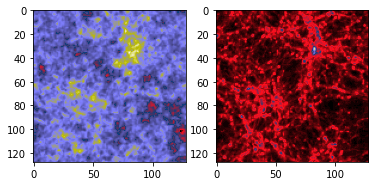

In [4]:
subplot(121)
imshow(cic_paint(jnp.zeros(mesh_shape), res[0]).sum(axis=0),cmap='gist_stern')
subplot(122)
imshow(cic_paint(jnp.zeros(mesh_shape), res[1]).sum(axis=0),cmap='gist_stern')